<center><h1>Step 0 - Preprocessing</h1></center> 

In this section, we first read the data including the bug reports and source code files of all 12 projects and for ease of access, we save them as two pickle files in the ./Output directory. Therefore, this set of code will populate the ./Output directory with "allBugReports.pickle" which is a pandas dataframe that contains all the bug reports from all projects and "allSourceCodes.pickle" which is a pandas dataframe that contains all source files after preprocessing.

### Required Libraries

In [3]:
!pip install javalang

In [4]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import warnings
import javalang
import re
import glob
import math
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm as tq
from time import gmtime, strftime
from random import randint
warnings.simplefilter(action='ignore', category=FutureWarning)

<center><h1>Splitting code and natural language</h1></center> 

<center><h1>Loading source codes into pandas Dataframe</h1></center> 

In [6]:
def classNames_methodNames(node):
    result=''
    if isinstance(node,javalang.tree.MethodDeclaration) or isinstance(node,javalang.tree.ClassDeclaration):
        return node.name.lower()+' '
    if not (isinstance(node,javalang.tree.PackageDeclaration) or
        isinstance(node,javalang.tree.FormalParameter) or
       isinstance(node,javalang.tree.Import)):
        if node:
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=classNames_methodNames(childNode)
    return result
    
def traverse_node(node,i=0):
    i+=1
    result=''
    if not(isinstance(node,javalang.tree.PackageDeclaration)
            or isinstance(node,javalang.tree.FormalParameter)            
            or isinstance(node,javalang.tree.Import)
            or isinstance(node,javalang.tree.CompilationUnit)):
        if node:
            if (isinstance(node,int) or isinstance(node,str) or isinstance(node,float)) and i==2:
                result+=node+' '
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=traverse_node(childNode,i)
    return result

def code_parser(code):
    try:
        tree = javalang.parse.parse(code)
        return ''.join([traverse_node(node) for path, node in tree]) + ' ' + ''.join([classNames_methodNames(node)
                                                                                      for path, node in tree])
    except Exception as e: 
        print(e)
        return ''

def loadSourceFiles2df(PATH,project):
    """
    Receives: group name and project name 
    Process: open the source file directory and finds all the java files,
             and after preprocessing(using code_preprocessor) load them into a pandas dataframe 
    Returns: dataframe >> "filename","code","size"
    """
    print('Loading source files of {}  ...'.format(project))
    PATH=os.path.join("data",project,"gitrepo")
    all_source_files=glob.glob(PATH+'/**/*.java', recursive=True)
    source_codes_df=pd.DataFrame([])
    sourceCodesList=[]

    for filename in tq(all_source_files):
        code=open(filename,encoding='ISO-8859-1').read()
        if 'src/' in filename:
            sourceCodesList.append(dict({"filename":filename.split('src/')[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
        else:
            sourceCodesList.append(dict({"filename":filename.split(project)[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
    source_codes_df=source_codes_df.append(pd.DataFrame(sourceCodesList))
    return source_codes_df

def load_all_SCs(dataPath):
    print('\tLoading all source codes ... ')
    source_codes_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        source_path=os.path.join(dataPath,project,"gitrepo")
        source_codes_df=source_codes_df.append(loadSourceFiles2df(source_path,project))
    return source_codes_df

<center><h1>Loading bug reports pandas Dataframe</h1></center> 

In [7]:
def loadBugs2df(PATH,project):
    """
    @Receives: the path to bug repository (the xml file)
    @Process: Parses the xml file and reads the fix files per bug id. 
    @Returns: Returns the dataframe
    """
    print("Loading Bug reports ... ")
    all_bugs_df=pd.DataFrame([],columns=["id","fix","text","fixdate"])
    bugRepo = ET.parse(PATH).getroot()
    buglist=[]                   
    for bug in tq(bugRepo.findall('bug')):
        bugDict=dict({"id":bug.attrib['id'],"fix":[],"fixdate":bug.attrib['fixdate']
                      ,"summary":None,"description":None,"project":project,"average_precision":0.0})
        for bugDetail in bug.find('buginformation'):
            if bugDetail.tag=='summary':
                bugDict["summary"]=bugDetail.text
            elif bugDetail.tag=='description':
                bugDict["description"]=bugDetail.text
        bugDict["fix"]=np.array([fixFile.text.replace('/','.').lower() for fixFile in bug.find('fixedFiles')])
        summary=str(bugDict['summary']) if str(bugDict['summary']) !=np.nan else ""
        description=str(bugDict['description']) if str(bugDict['description']) !=np.nan else ""
        buglist.append(bugDict)
    all_bugs_df=all_bugs_df.append(pd.DataFrame(buglist))
    return all_bugs_df.set_index('id')

def load_all_BRs(dataPath):
    print('\tLoading all bug reports ... ')
    all_bugs_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        data_path=os.path.join(dataPath,project,"bugrepo","repository.xml")
        all_bugs_df=all_bugs_df.append(loadBugs2df(data_path,project))
        print(len(all_bugs_df))
    return all_bugs_df


<center><h1>Main Preprocessing class</h1></center> 

In [8]:
class PreprocessingUnit:
    all_projects_source_codes=pd.DataFrame([])
    all_projects_bugreports=pd.DataFrame([])
    
    def __init__(self,dataPath):
        self.dataPath=dataPath
        self.dataFolder=os.path.join(os.getcwd(),'Output')
        if not os.path.exists(self.dataFolder):
            os.makedirs(self.dataFolder)
            
    def execute(self):
        self.loadEverything()

    def loadEverything(self):
        vectorize=False
        if PreprocessingUnit.all_projects_bugreports.empty:
            bugReportFile=os.path.join(self.dataFolder,'allBugReports.pickle')
            if not os.path.isfile(bugReportFile):
                PreprocessingUnit.all_projects_bugreports=load_all_BRs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_bugreports.to_pickle(bugReportFile)
            else: 
                PreprocessingUnit.all_projects_bugreports=pd.read_pickle(bugReportFile)
        print("*** All bug reports are are preprocessed and stored as: {} ***".format('/'.join(bugReportFile.split('/')[-2:])))

        if PreprocessingUnit.all_projects_source_codes.empty:
            sourceCodeFile=os.path.join(self.dataFolder,'allSourceCodes.pickle')
            if not os.path.isfile(sourceCodeFile):
                PreprocessingUnit.all_projects_source_codes=load_all_SCs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_source_codes.to_pickle(sourceCodeFile)
            else:
                PreprocessingUnit.all_projects_source_codes=pd.read_pickle(sourceCodeFile)
        print("*** All source codes are preprocessed and stored as: {} ***".format('/'.join(sourceCodeFile.split('/')[-2:])))
        

### MAIN

In [9]:
if __name__=="__main__":
    config={'DATA_PATH':os.path.join('data')}
    preprocessor=PreprocessingUnit(dataPath=config['DATA_PATH'])
    preprocessor.execute()

*** All bug reports are are preprocessed and stored as: Output/allBugReports.pickle ***
*** All source codes are preprocessed and stored as: Output/allSourceCodes.pickle ***


In [10]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()
display(len(all_projects_bugreports))
display(len(all_projects_source_codes))



*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


1858

10461

# ASSIGNMENT START

There are several software engineering (SE) problems that can be investigated using machine learning. Among them, we will be working on a problem called "Fault Localization" (FL). The goal of FL is to automatically locate a fault entity (e.g. a source file, a class, a method, etc) in source code. There are different variations of FL and we will focus on Information Retrieval based FL (IRFL). This article explains FL: https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=2530&context=sis_research

In short, the idea is, given a new bug report document, we want to automatically identify the source code file that most likely needs a fix, so we can save time for debugging. 

To do this, we may use the previous bug resports and identify the locations (files) that have been patched as our training set. So, we build an IRFL model that:

- Finds the textual similarity between the new bug report and the historical ones. 
- Then rank historically patched source files based on how similar their bug reports are to the new bug report.

# Let's import some things that will help us

In [11]:
# Key Imports
import re
import sys
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import multiprocessing as mp
from copy import deepcopy
import matplotlib.pyplot as plt

cores = mp.cpu_count()

# Download some stuff to run the code
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/justintijunelis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justintijunelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Pre-processing

First, we need to create our training set. Using `all_projects_bug_reports` and `all_projects_source_codes`.

We will clean the bug report and source code text by creating a function that will:

1. Make all text lowercase.
2. Remove all punctuation from the text and replace it with white space.
3. Remove all repetitive white space from the text.
4. Remove imports and packages from source code as they are not that likely to impact our bug finding ability.
5. Space out words in camel case variables as these may provide some depth.
6. Remove all numbers as these are unlikely to be relevant, especially with noise in comments like copyright years.
7. Replace all duplicate white space with singular white space.
8. Tokenize the filtered string and removes stem words

Then, we will clean the bug reports by:

1. Concatenating the bug summary and description, then using the our cleaner we developed earlier.
2. Dropping any reports that are composed of entirely stopped and/or banned words.
3. We can drop the summary and description since we will only process once.

Then, we will clean the source code files by:

1. Apply the clean text function to the source code.
2. Renaming `unprocessed_code` to `code`.
3. Dropping any source code that does not contain any filtered text.

Finally, the author noticed that some of the bug reports fixed files no longer exist! These bug reports should be dropped entirely.

# Potential Improvements

There may be some commonalities that we could remove that are language specific. For example, words like class, void, public, private, and other common syntax in Java could help us identify the more unique parts of the source code. Additionally, we could remove copyright notices that are shared between all files. Finally, we could try to do an analysis of results with different filtering methods and see which methods create the greatest statistical difference. We could use a two-sample proportions test or a variety of other tests that could tell us if making changes makes a statistical difference. Unfortunately, the author of this report has other homework and is pretty burnt out.

One further improvement to cleaning out irrelevant data is finding bug reports where some fixed files still exist, but others do not, and thus removing the files from the fixed list if they do not exist, and keeping the ones that do still exist. Although, one could argue that if any of the fixed files are missing, they should be removed entirely.

We could also argue that files that have tests for them are less likely to have bugs, so we could apply some sort of weighting for files that do/don't have tests.

In [12]:
def clean_text(text):
  # Remove imports
  text = re.sub(r"import\s.*;", "", text)
  # Remove packages
  text = re.sub(r"package\s.*;", "", text)
  # Space out camel case (https://stackoverflow.com/questions/5020906/python-convert-camel-case-to-space-delimited-using-regex-and-taking-acronyms-in)
  text = re.sub(r"((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))", r" \1", text)
  # Replace punctuation with spaces (https://stackoverflow.com/questions/68590438/replace-punctuation-with-space-in-text)
  text = re.sub(r"(?:[^\w\s]|_)+", " ", text)
  # Replace white space or repeating whitespace with single space
  text = re.sub("\s+", " ", text) 
  # Remove all numbers
  text = re.sub(r"[0-9]+", "", text)
  # Remove HTML tags? # Remove static, int, char, etc
  
  # Make everything lowercase
  text = text.lower()

  # Tokenize the words, remove all stop words, and a list of common words we don't want to include
  banned_tokens = ["copyright", "void"]
  tokenized = word_tokenize(text) 
  tokens = []
  for token in tokenized:
    if token not in stopwords.words('english') and token not in banned_tokens:
      tokens.append(token)

  # Stem all words using Porter Stemming
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(token) for token in tokens]

  # Recreate the text
  return " ".join(tokens)

def process_bug_reports(bug_reports):
  reports_to_drop = []
  for row, bug_report in bug_reports.iterrows():
    description = bug_report['description']
    summary = bug_report['summary']
    bug_text = ""
    if isinstance(description, str):
      bug_text += description
    if isinstance(summary, str):
      bug_text += summary
    bug_text = clean_text(bug_text)

    # Skip and delete the row if the bug text is empty
    if bug_text == "":
      reports_to_drop.append(row)
    else:
      bug_reports.at[row, 'text'] = bug_text

  # Drop bad reports and unnecessary columns
  bug_reports.drop(reports_to_drop, axis = 0, inplace = True)
  bug_reports.drop('summary', axis = 1, inplace = True)
  bug_reports.drop('description', axis = 1, inplace = True)
  bug_reports['similarities'] = [[] for _ in range(len(bug_reports))]
  return bug_reports

def process_source_files(source_files):
  source_files['unprocessed_code'] = source_files['unprocessed_code'].apply(lambda t: clean_text(t))
  source_files.rename(columns={"unprocessed_code": "code"}, inplace = True)
  source_files = source_files[source_files['code'] != ""]
  return source_files

def remove_irrelevant_bug_reports(bug_reports, source_files):
  """
  This function removes bug reports in place where its fixed source files could not be found in the existing dataset.
  """
  # Split the source files into project to improve loop efficiency (only search relevant source files for bugs)
  projects = bug_reports['project'].unique()
  project_source_files = defaultdict()
  for project in projects:
    project_source_files[project] = source_files[source_files['project'] == project]['filename']
  
  # Remove the bug reports for which no fixed source files could be found
  reports_to_drop = []
  for row, bug_report in bug_reports.iterrows():
    fixed_files = bug_report['fix']
    fixed_files_found = 0
    for fixed_file in fixed_files:
      for existing_file in project_source_files[bug_report['project']]:
        if fixed_file in existing_file or fixed_file == existing_file:
          fixed_files_found += 1
    if fixed_files_found == 0:
      reports_to_drop.append(row)

  # Remove the irrelevant bug reports
  bug_reports.drop(reports_to_drop, axis = 0, inplace = True)
      

Process the bug reports and source files using multiprocessing. This will take quite a while on anyone's computer. Time on an M1 Apple laptop took about 2 minutes.

If you are on a PC, a windows version of the code will be executed below. However, the author of the code does not have a windows machine to test on right now so it is likely to fail. Worst case, call the functions directly without any multiprocessing, but make sure to pass copies of the dataframes, not references.

In [13]:
if __name__ == "__main__":
  if os.name == 'posix':
    with mp.get_context('fork').Pool(processes = cores) as p:
      bug_reports = pd.concat(
        p.map(
          process_bug_reports, 
          np.array_split(all_projects_bugreports.copy(), cores)
        )
      )
    with mp.get_context('fork').Pool(processes = cores) as p:
      source_files = pd.concat(
        p.map(
          process_source_files, 
          np.array_split(all_projects_source_codes.copy(), cores)
        )
      )
  elif os.name == 'nt': # This MIGHT work
    with mp.Pool(processes = cores) as p:
      bug_reports = pd.concat(
        p.map(
          process_bug_reports, 
          np.array_split(all_projects_bugreports.copy(), cores)
        )
      )
    with mp.Pool(processes = cores) as p:
      source_files = pd.concat(
        p.map(
          process_source_files, 
          np.array_split(all_projects_source_codes.copy(), cores)
        )
      )
  elif os.name == 'java':
    # Sorry
    pass
  remove_irrelevant_bug_reports(bug_reports, source_files)

# Calculating Similarities

Since our dataset has multiple projects, and each project has multiple bug reports, we don't want to compare bug reports with files of a project they don't belong to. So, we will compare a bug report to all the files in its respective project. 

To compute similarity between a bug report and it's project file:

1. Iterate through each file of the bug report's project.
2. Create a TF-IDF vectorizer and fit and transform the file's source code since we want to compare against the source code.
3. Transform the bug report's text with the vectorizer.
4. Compare the similarity of the two resulting vectors using cosine distance.

We will iterate through each bug report and generate its similarity, then return a list of similarities that will implicitely map to each bug report.

Note that inverting the vectorizer transform order was attempted but yielded worse results. This is likely because we want to fit on a larger dataset and compare bug descriptions against source code, rather than comparing source code against a bug description.

We set the `sublinear_tf` to `True` for the TfidfVectorizer as the BugLocator paper indicated that this could lead to better performance. In fact, this led to a slight bump in performance. The paper uses a revised Vector Space Model to compute similarities between documents which accounts for the finding that longer source code files are more likely to have bugs. Since TF-IDF will give more weight to shorter documents, they applied their method to provide more weight to larger documents. Given the complexity of implementing their algorithm from scratch, we will utilize the TfidfVectorizer provided by scikit-learn.

In [14]:
def calculate_similarity(bug_report, source_files):
  # Find the similarity score
  vectorizer = TfidfVectorizer(sublinear_tf = True)
  source_vector = vectorizer.fit_transform(source_files['code'])
  bug_vector = vectorizer.transform([bug_report['text']])
  similarity_score = cosine_similarity(source_vector, bug_vector)

  # Number of terms
  inverse_logits = []
  for text in source_files['code']:
    inverse_logits.append(len(set(text.split())))
  # Normalize the terms
  x_max = max(inverse_logits)
  x_min = min(inverse_logits)
  for i, value in enumerate(inverse_logits):
    normalized = (value - x_min) / (x_max - x_min)
    inverse_logits[i] = normalized
  # Apply the inverse logit
  for i, value in enumerate(inverse_logits):
    inverse_logits[i] = 1 / (1 + math.exp(-value))

  # Extract the score
  scores = []
  for inverse_logit, score in zip(inverse_logits, similarity_score):
    scores.append(inverse_logit * score[0])

  # Let's normalize the scores
  x_max = max(scores)
  x_min = min(scores)
  for i, score in enumerate(scores):
    normalized = (score - x_min) / (x_max - x_min)
    scores[i] = normalized

  # Sort the values
  df = pd.DataFrame()
  df['scores'] = np.array(scores)
  df['files'] = source_files['filename'].values
  df = df.sort_values('scores', ascending = False)

  # Create a tuple array
  tuples = []
  for file, score in zip(df['files'].values, df['scores'].values):
    tuples.append((file, score))
  return tuples

def compute_similarities(bug_reports, source_files):
  for row, bug_report in bug_reports.iterrows():
    bug_reports.at[row, 'similarities'] = calculate_similarity(bug_report, source_files)
  return bug_reports


Compute the similarities. Again, this was built to run on POSIX machines, but there is code to run on Windows. However, it may not work as the author has not tested on a windows machine.

In [15]:
if __name__ == "__main__":
  # Create project groups for bugs and source files and processes them separately
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]
  project_source_files = [group for _, group in source_files.groupby('project')]
  if os.name == 'posix':
    with mp.get_context('fork').Pool(processes = len(project_bug_reports)) as p:
      bug_reports = pd.concat(
        p.starmap(
          compute_similarities,
          zip(project_bug_reports, project_source_files)
        )
      )
  elif os.name == 'nt':
    with mp.Pool(processes = len(project_bug_reports)) as p:
      bug_reports = pd.concat(
        p.starmap(
          compute_similarities,
          zip(project_bug_reports, project_source_files)
        )
      )
  elif os.name == 'java':
    # Sorry
    pass

# MRR (Mean Reciprocal Rank) scores

Our dataset doesn't quite fit with the MRR formula, so we have to improvise. The MRR formula assumes that there is only one query element for a search set (e.g. for set A, B, C, we have a query of A). Since we have a list of queries (e.g. for a set A, B, C, we have a query A, B), our query is a subset of the search set, rather than an element. 

If our query is A, B and the search set is A, B, C, we expect our MRR to be 1. However, using the formula would give us 3/4. So, what we can do is iterate through each element of the query and calculate an MRR, then, *remove* that query element from the subset. 

It looks something like this:

- Query: A, B -> Search Set: A, B, C
- Calculate MRR for A -> 1/1
- Remove A from the Search Set, which becomes: B, C
- Query A -> Search Set: B, C
- Calculate MRR for B -> 1/1
- Remove B from the Search Set, which becomes: C
- Done
- Calculate Adjusted MRR with: (MRR_A + MRR_B)/2 = 1

BUT, what happens if the query is B, A? We still get an adjusted score of 3/4. To avoid this, we need to *sort* the query to be in the same order as the elements appear in the search set.

We use the following formula for finding MRR:

$MRR = \frac{1}{|Q|}\sum_{i=1}^{|Q|} \frac{1}{rank_i}$



In [16]:
def calculate_adjusted_MRR(bug_report, score_label):
  fixed_files = bug_report['fix']
  project_file_similarities = deepcopy(bug_report[score_label])

  # Sort the fixed files to be in the same order as they appear in the project file similarities
  i = 0
  temp_fixed_files = []
  for similarity in project_file_similarities:
    file = similarity[0]
    if len(temp_fixed_files) == len(fixed_files):
      break
    for f in fixed_files:
      if f in file or f == file:
        temp_fixed_files.append(file)

  # Otherwise, we will get an error, if we can't find any documents the score is 0.
  if len(temp_fixed_files) == 0:
    return 0
  fixed_files = temp_fixed_files

  # Calculate the MRR for the bug report
  adjusted_reciprocals = []
  for fixed_file in fixed_files:
    # Find the ranking of the fixed file in the similarities array
    similarity_index = 1
    for i, similarity in enumerate(project_file_similarities):
      file, _ = similarity
      if file in fixed_file:
        similarity_index = i + 1
        break

    # Calculate the similarity and shift the window
    adjusted_reciprocals.append(1 / similarity_index)
    del project_file_similarities[similarity_index - 1]

  return np.mean(adjusted_reciprocals)

# MAP (Mean Average Precision) scores

To calculate the MAP, the formula described in the BugLocator paper along with other online research was utilized. There was a bug in the BugLocator paper that showed the variable with an `i` variable that should have been `j`, this was realized using the author's neural net when conducting secondary research. 

Average Precision of each query (bug):

$AvgP_i = \sum_{j=1}^{M} \frac{P(j) × pos(j)}{\text{number of positive instances}}$

- Where *M* is the number documents.
- *P(j)* is the number of positive instances in the top *j* positions.
- *pos(j)* is whether the document at j is equal to a document in the query.
- number of positive instances is the total number of query documents that are found in the documents.

The MAP is the mean of all precisions.

In [17]:
def calculate_average_precision(bug_report, score_label):
  fixed_files = bug_report['fix']
  similarities = bug_report[score_label]

  # Precompute some queries, otherwise this function will take hours to run if we do this in the for loop
  fixed_file_indices = []
  for fix in fixed_files:
    for i in range(len(similarities)):
      if fix in similarities[i][0] or fix == similarities[i][0]:
        fixed_file_indices.append(i)

  # Calculate the average precision outlined in the BugLocator paper
  precision = []
  for j in range(len(similarities)):
    if j + 1 == len(similarities):
      break

    # Calculate P(j)
    number_of_positive_instances_in_top_j = 0
    for index in fixed_file_indices:
      if index <= j:
        number_of_positive_instances_in_top_j += 1
    p_j = number_of_positive_instances_in_top_j / (j + 1)

    # Calculate pos(j)
    pos_j = 0
    document_j = similarities[j]
    for file in fixed_files:
      if file in document_j[0] or file == document_j[0]:
        pos_j = 1

    precision.append((p_j * pos_j) / len(fixed_files))

  return sum(precision)

# Let's create a function to calculate the scores

In [18]:
def calculate_scores(bug_reports, metric_function, column_name, score_label):
  # Calculate the average precision for each bug report
  for row, bug_report in bug_reports.iterrows():
    score = metric_function(bug_report, score_label)
    bug_reports.at[row, column_name] = score

  # Group the project bugs, and compute the net MAP per project
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]
  project_scores = defaultdict()
  projects = bug_reports['project'].unique()
  for project in projects:
    project_scores[project] = 0
  for project_bug_report in project_bug_reports:
    score = np.mean(project_bug_report[column_name])
    project_scores[project_bug_report['project'][0]] = score
  
  return project_scores

# Let's visualize our results for MRR

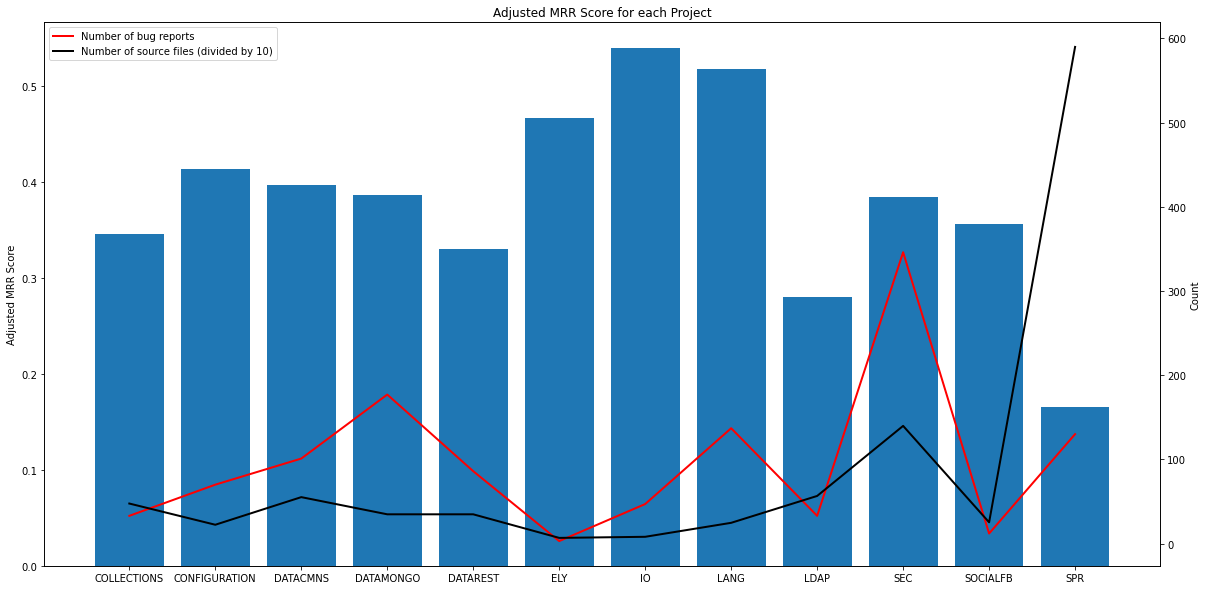

In [19]:
# Get the bug and source file counts
bug_report_counts = [(project, len(group)) for project, group in bug_reports.groupby('project')]
source_file_counts = [(project, len(group) / 10) for project, group in source_files.groupby('project')]

# Calculate and plot the MRR
project_scores = calculate_scores(bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'similarities')

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MRR Score')
ax1.bar(range(len(project_scores)), list(project_scores.values()), tick_label=list(project_scores.keys()))

ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in bug_report_counts], [p[1] for p in bug_report_counts], label = "Number of bug reports", color="red", linewidth = 2)
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth = 2)

plt.title('Adjusted MRR Score for each Project')
plt.legend()
plt.show()

# Let's visualize our results for MAP

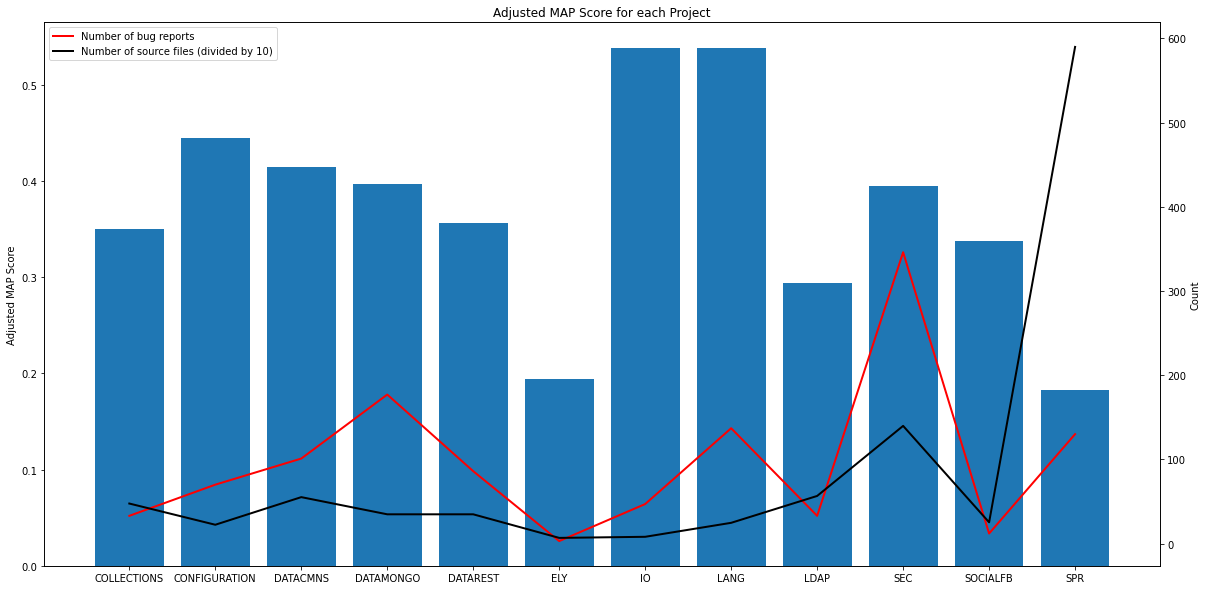

In [17]:
# Get the bug and source file counts
bug_report_counts = [(project, len(group)) for project, group in bug_reports.groupby('project')]
source_file_counts = [(project, len(group) / 10) for project, group in source_files.groupby('project')]

# Calculate and plot the MRR
project_scores = calculate_scores(bug_reports, calculate_average_precision, 'average_precision', 'similarities')

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MAP Score')
ax1.bar(range(len(project_scores)), list(project_scores.values()), tick_label=list(project_scores.keys()))

ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in bug_report_counts], [p[1] for p in bug_report_counts], label = "Number of bug reports", color="red", linewidth=2)
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth=2)

plt.title('Adjusted MAP Score for each Project')
plt.legend()
plt.show()

# Method 2

In this step, we will develop a new IRFL method and comparing to Method 1.

We will roughly implement the BugLocator tool. We will use the same preprocessing as TF-IDF code we developed for method 1 to calculate an indirect relevancy function. Then, we will use a weighted average of the direct relevancy function and indirect relevancy function to do the ranking for this method. The indirect function calculates the similarity between the new bug report and the historical ones. Then, given that we already know which exact files have been fixed for each historical bug report. So, we can map files to historical bug reports. Then, the algorithm ranks source files according to their indirect similarity (the similarity of a source file's corresponding historical report(s) to the new bug report) to the new bug report.

- Method 2 MUST improve method 1 results.
 

# First, let's get our data in order

We need to split our bug reports into testing and training sets. Since the bugs are dated, we can sort them to use the newest bugs as our testing set and historical bugs as our training set. We will split the training set as the oldest 80% of the bug reports and the testing set as the newest 20% of the reports.

But, we need to be careful! Some projects have more source code than others. We need to make sure we *evenly* split the bug reports into testing and training sets for *each* project.

In [57]:
def split_testing_training(bug_reports):
  # Split the dataset into project bug reports
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]

  # Split the project reports by data with an 80/20 training/testing split
  testing_bug_reports = []
  training_bug_reports = []
  for project_reports in project_bug_reports:
    project_reports.sort_values('fixdate', inplace = True, ascending = True)
    break_index = math.ceil((len(project_reports) - 1) * .8)
    testing_bug_reports.append(project_reports.iloc[break_index:, :])
    training_bug_reports.append(project_reports.iloc[:break_index, :])

  # Create pandas
  testing_bug_reports = pd.concat(testing_bug_reports)
  training_bug_reports = pd.concat(training_bug_reports)

  return (testing_bug_reports, training_bug_reports)

testing_bug_reports, training_bug_reports = split_testing_training(bug_reports.copy())
testing_bug_reports['indirect_relevancies'] = np.empty((len(testing_bug_reports), 0)).tolist()
testing_bug_reports['final_scores'] = np.empty((len(testing_bug_reports), 0)).tolist()


# Indirect Relevancy Function

We will define the indirect relevancy function as follows:

By comparing new bug reports to old ones, we can compute the similarity using the same methods as in Method 1. This function assumes that if two bugs are similar, their fixed source code files are relevant to each other. Thus, we can compute the similarity between bugs using TF-IDF, then rank the similarity of bugs and their respective source files. 

Note that the BugLocator paper implements a custom similarity score between bug reports and source files, but does not explicitely mention their similarity scoring method between bugs. It is likely that they used their rVSM method to compute these similarities, but we will not be doing that. Instead, we will just use the TfidfVectorizer from scikit-learn.

To calculate the SimiScore, we will use the following from the BugLocator paper:

$SimiScore = \sum_{\text{All } S_i \text{that connects to } F_j}^{} \frac{Similarity(B, S_i)}{n_i}$

- Where $B$ is the new bug to be located (a bug in the testing set)
- Where $S_i$ is a bug related to a file $F_j$
- Where $n_i$ is the total number of fixed files $S_i$ has

In [70]:
def compute_indirect_relevancy(testing_report, training_reports):
  # First, we find the similarity score for B, S_i
  vectorizer = TfidfVectorizer(sublinear_tf = True)
  training_vector = vectorizer.fit_transform(training_reports['text'])
  testing_vector = vectorizer.transform([testing_report['text']])
  similarity_score = cosine_similarity(testing_vector, training_vector)

  # Extract the scores, this list will be in the same order as testing reports
  scores = []
  for score in similarity_score:
    # Apply inverse logit function to each
    scores.append(score[0])

  # Find all bug reports linked to F_j
  file_reports = defaultdict()
  for _, testing_report in training_reports.iterrows():
    for file in testing_report['fix']:
      if file not in file_reports:
        file_reports[file] = []
      file_reports[file].append(testing_report)

  # Calculate the SimiScore for each file
  simi_scores = []
  for file in file_reports.keys():
    simi_score_sum = []
    for bug_report in file_reports[file]:
      n_i = len(bug_report['fix'])
      # Find the index of the testing report in the scores
      score_index = 0
      for _, testing_report in training_reports.iterrows():
        if testing_report.index[0] == bug_report.index[0]:
          break
        score_index += 1
      score = scores[score_index]
      simi_score_sum.append(score / n_i)
    simi_scores.append((file, sum(simi_score_sum)))

  # Finally, let's normalize the simi scores
  x_max = max(x[1] for x in simi_scores)
  x_min = min(x[1] for x in simi_scores)
  for i, score in enumerate(simi_scores):
    if x_max - x_min == 0:
      simi_scores[i] = (score[0], 0)
    else:
      normalized = (score[1] - x_min) / (x_max - x_min)
      simi_scores[i] = (score[0], normalized)
  simi_scores = sorted(simi_scores, key = lambda x: x[1], reverse = True)

  return simi_scores

def compute_indirect_relevancies(training_reports, testing_reports):
  for row, testing_report in testing_reports.iterrows():
    testing_reports.at[row, 'indirect_relevancies'] = compute_indirect_relevancy(testing_report, training_reports)
  return testing_reports

Compute the indirect relevancy. Again, this was built to run on POSIX machines, but there is code to run on Windows. However, it may not work as the author has not tested on a windows machine.

In [71]:
if __name__ == "__main__":
  # Create project groups for testing and training bugs and process them separately
  project_testing_bug_reports = [group for _, group in testing_bug_reports.groupby('project')]
  project_training_bug_reports = [group for _, group in training_bug_reports.groupby('project')]
  if os.name == 'posix':
    with mp.get_context('fork').Pool(processes = len(project_bug_reports)) as p:
      testing_bug_reports = pd.concat(
        p.starmap(
          compute_indirect_relevancies,
          zip(project_training_bug_reports, project_testing_bug_reports)
        )
      )
  elif os.name == 'nt':
    with mp.Pool(processes = len(project_bug_reports)) as p:
      bug_reports = pd.concat(
        p.starmap(
          compute_similarities,
          zip(project_bug_reports, project_source_files)
        )
      )
  elif os.name == 'java':
    # Sorry
    pass

# Let's calculate the final score

Using the formula from the BugLocator paper, except we will use our TFIDF score from scikit-learn's library:

$\text{Final Score} = (1 - α)×N(\text{TFIDF Score}) + α × N(SimiScore)$

- Where $α$ is a weighting constant.

The scores were normalized previously using the formula from the BugLocator paper:

$N(x) = \frac{x - x_{min}}{x_{max} - x_{min}}$

In [72]:
def calculate_final_scores(bug_reports, α):
  all_final_scores = []
  # Get the final score for each bug report (testing)
  for _, bug_report in bug_reports.iterrows():
    final_scores = []
    indirect_relevancies = bug_report['indirect_relevancies']
    # Compute the final score
    for similarity in bug_report['similarities']:
      file = similarity[0]
      score = similarity[1]

      # Find the corresponding indirect relevance score for the similarity to calculate the final score
      corresponding_relevancy = 0
      for ir in indirect_relevancies:
        if ir[0] == file or ir[0] in file:
          corresponding_relevancy = ir[1]
          break
        
      final_score = ((1 - α) * score) + (α * corresponding_relevancy)
      final_scores.append((file, final_score))
    
    # We need to sort to calculate the MRR scores
    final_scores = sorted(final_scores, key = lambda x: x[1], reverse = True)
    all_final_scores.append(final_scores)
  return all_final_scores

# Let's check MRR and MAP scores with different α values

In [73]:
def plot_scores_vs_α(*args):
  metric_scores = defaultdict()
  α_range = [α / 100 for α in range(0, 105, 5)]

  for α in α_range:
    all_final_scores = calculate_final_scores(testing_bug_reports, α)
    testing_bug_reports['final_scores'] = all_final_scores
    scores = calculate_scores(*args)
    scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse = True))
    for k, v in scores.items():
      if k not in metric_scores:
        metric_scores[k] = []
      metric_scores[k].append(v)
  
  return metric_scores

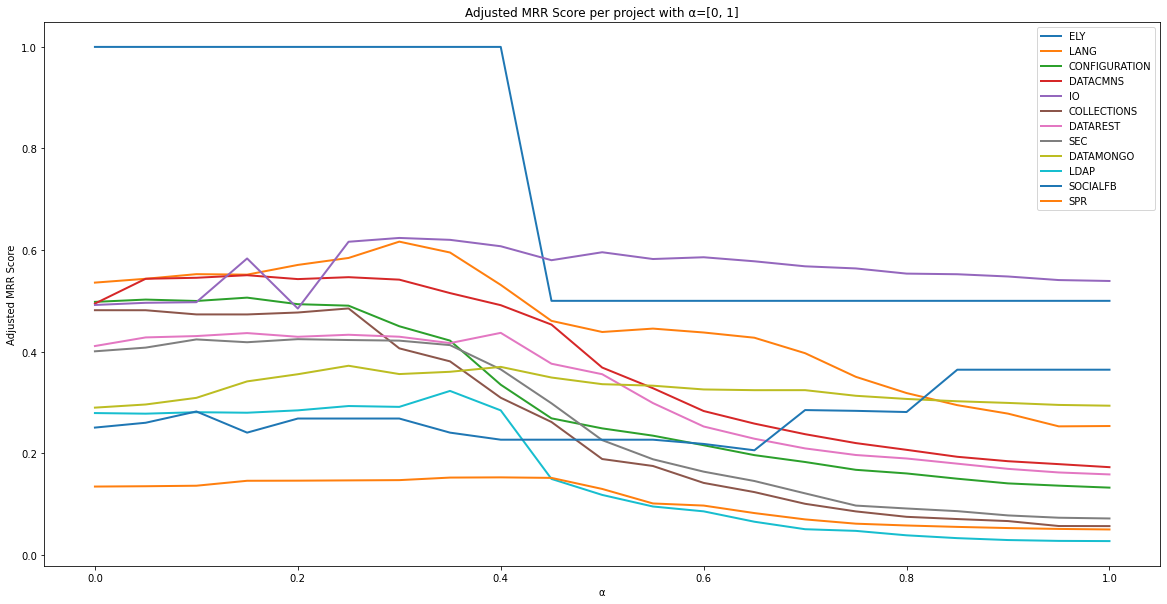

In [74]:
# Plot MRR scores
α_range = [α / 100 for α in range(0, 105, 5)]
metric_scores = plot_scores_vs_α(testing_bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'final_scores')
for k, v in metric_scores.items():
  plt.plot(α_range, v, label = k, linestyle = "-", linewidth=2)
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('Adjusted MRR Score per project with α=[0, 1]')
plt.xlabel('α')
plt.ylabel('Adjusted MRR Score')
plt.legend()
plt.show()

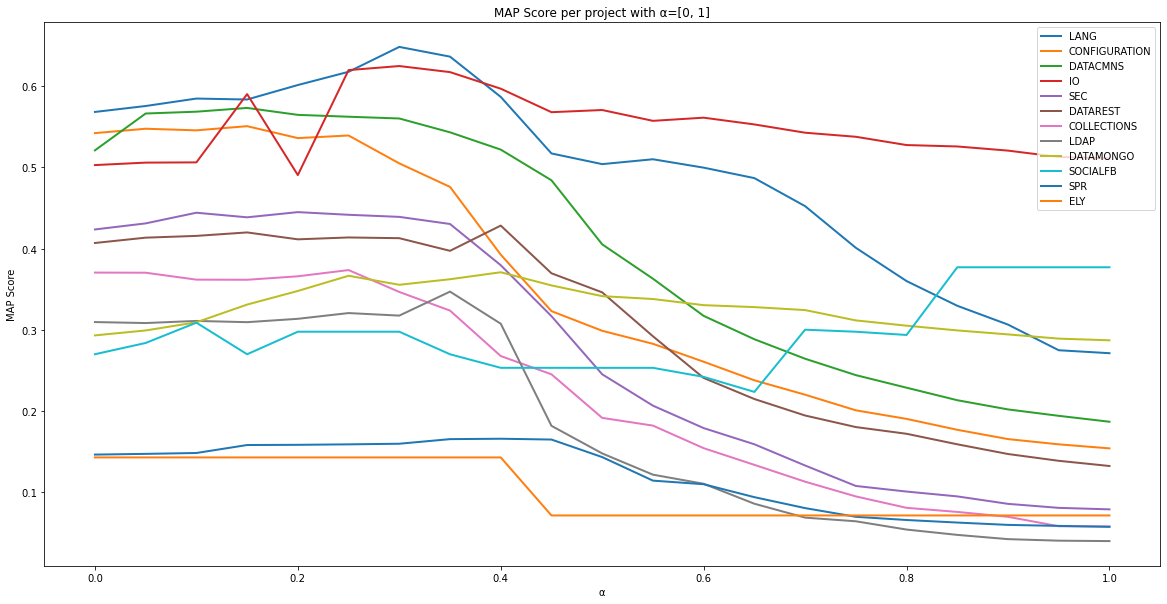

In [75]:
# Plot MAP scores
α_range = [α / 100 for α in range(0, 105, 5)]
metric_scores = plot_scores_vs_α(testing_bug_reports, calculate_average_precision, 'average_precision', 'final_scores')
for k, v in metric_scores.items():
  plt.plot(α_range, v, label = k, linestyle = "-", linewidth=2)
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('MAP Score per project with α=[0, 1]')
plt.xlabel('α')
plt.ylabel('MAP Score')
plt.legend()
plt.show()

# Comparing Method 1 and 2 MRR Scores with α in range [0, 1]

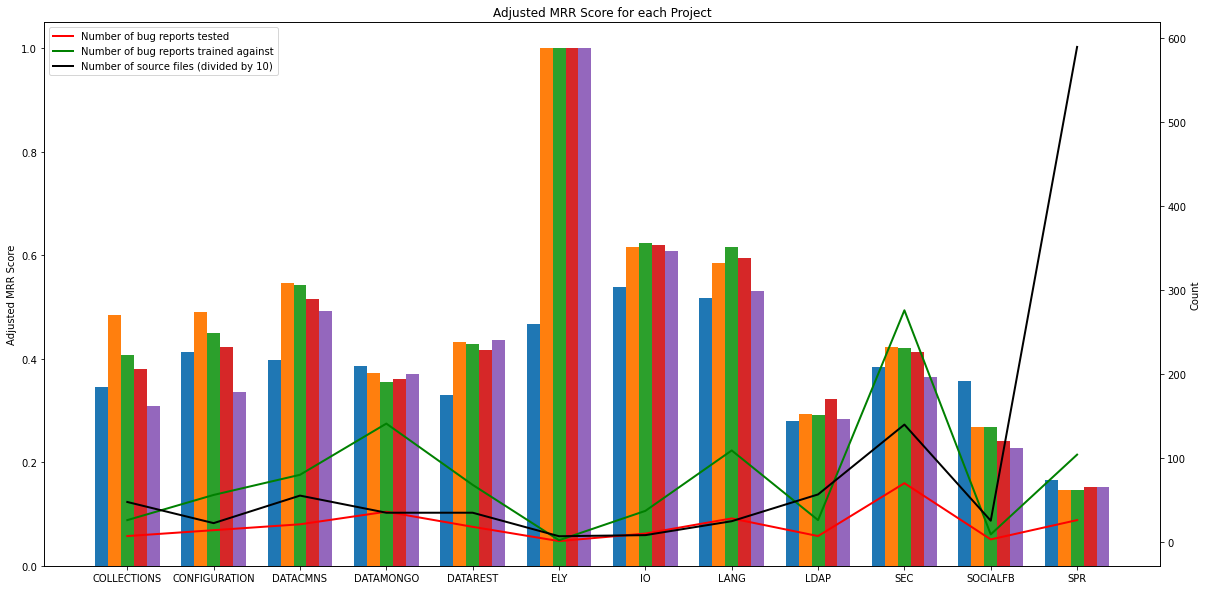

In [76]:
# Get the scores
method1_scores = calculate_scores(bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'similarities')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.25)
method2_scores_α025 = calculate_scores(testing_bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'final_scores')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.3)
method2_scores_α030 = calculate_scores(testing_bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'final_scores')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.35)
method2_scores_α035 = calculate_scores(testing_bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'final_scores')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.40)
method2_scores_α040 = calculate_scores(testing_bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'final_scores')

# Get the counts
testing_bug_report_counts = [(project, len(group)) for project, group in testing_bug_reports.groupby('project')]
training_bug_report_counts = [(project, len(group)) for project, group in training_bug_reports.groupby('project')]
source_file_counts = [(project, len(group) / 10) for project, group in source_files.groupby('project')]

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MRR Score')
labels = list(method1_scores.keys())
x = np.arange(len(labels))
width = 0.15
ax1.bar(x - 0.3, list(method1_scores.values()), width, label="Method 1")
ax1.bar(x - 0.15, list(method2_scores_α025.values()), width, label="Method 2; α = 0.25")
ax1.bar(x + 0.0, list(method2_scores_α030.values()), width, label="Method 2; α = 0.30")
ax1.bar(x + 0.15, list(method2_scores_α035.values()), width, label="Method 2; α = 0.35")
ax1.bar(x + 0.3, list(method2_scores_α040.values()), width, label="Method 2; α = 0.40")

# Plot the counts
ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in testing_bug_report_counts], [p[1] for p in testing_bug_report_counts], label = "Number of bug reports tested", color="red", linewidth=2)
ax2.plot([p[0] for p in training_bug_report_counts], [p[1] for p in training_bug_report_counts], label = "Number of bug reports trained against", color="green", linewidth=2)
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth=2)

plt.title('Adjusted MRR Score for each Project')
plt.legend()
plt.show()

# Comparing Method 1 and 2 MAP Scores with α in range [0, 1]

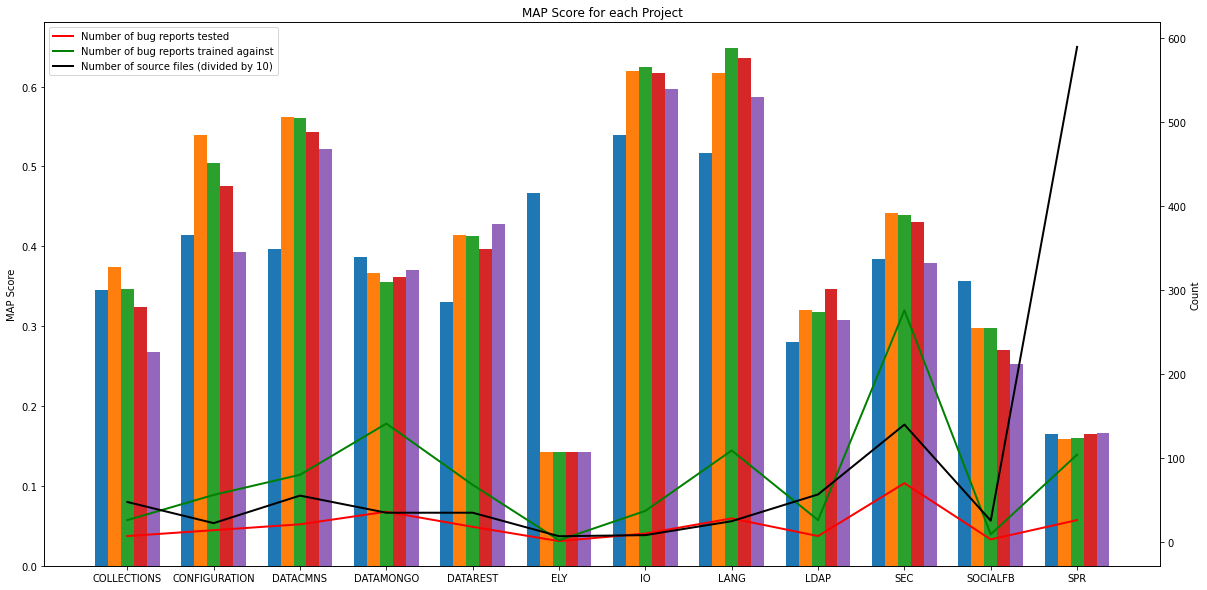

In [77]:
# Comparing Method 1 and 2 MAP scores
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.25)
method2_scores_α025 = calculate_scores(testing_bug_reports, calculate_average_precision, 'average_precision', 'final_scores')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.3)
method2_scores_α030 = calculate_scores(testing_bug_reports, calculate_average_precision, 'average_precision', 'final_scores')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.35)
method2_scores_α035 = calculate_scores(testing_bug_reports, calculate_average_precision, 'average_precision', 'final_scores')
testing_bug_reports['final_scores'] = calculate_final_scores(testing_bug_reports, 0.40)
method2_scores_α040 = calculate_scores(testing_bug_reports, calculate_average_precision, 'average_precision', 'final_scores')

# Get the counts
testing_bug_report_counts = [(project, len(group)) for project, group in testing_bug_reports.groupby('project')]
training_bug_report_counts = [(project, len(group)) for project, group in training_bug_reports.groupby('project')]
source_file_counts = [(project, len(group) / 10) for project, group in source_files.groupby('project')]

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('MAP Score')
labels = list(method1_scores.keys())
x = np.arange(len(labels))
width = 0.15
ax1.bar(x - 0.3, list(method1_scores.values()), width, label="Method 1")
ax1.bar(x - 0.15, list(method2_scores_α025.values()), width, label="Method 2; α = 0.25")
ax1.bar(x + 0.0, list(method2_scores_α030.values()), width, label="Method 2; α = 0.30")
ax1.bar(x + 0.15, list(method2_scores_α035.values()), width, label="Method 2; α = 0.35")
ax1.bar(x + 0.3, list(method2_scores_α040.values()), width, label="Method 2; α = 0.40")

# Plot the counts
ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in testing_bug_report_counts], [p[1] for p in testing_bug_report_counts], label = "Number of bug reports tested", color="red", linewidth=2)
ax2.plot([p[0] for p in training_bug_report_counts], [p[1] for p in training_bug_report_counts], label = "Number of bug reports trained against", color="green", linewidth=2)
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth=2)

plt.title('MAP Score for each Project')
plt.legend()
plt.show()

# Let's pick our favourite scores

In [79]:
all_final_scores = calculate_final_scores(testing_bug_reports, 0.3)
testing_bug_reports['final_scores'] = all_final_scores

# Findings

Clearly, method 2 outperforms method 1. However, the method does not outperform for the `COLLECTIONS`, `CONFIGURATION`, and `DATACMNS` projects.

Our results, for the most part, are consistent with the findings of the BugLocator paper. Hurray! From the plots shown, one could correlate higher scores with more source files and more bug reports. However, this is not conclusive. The more likely reason for some projects performing better than others is in the textual data and quality of bug reports. For some projects, their performance using entirely historical bug report data leads to better results than comparing reports to source code. 

Some factors that are likely to lead to better results includes code quality, variable naming, source file design, and commenting. One potential failure of this implementation is accounting for file size using the BugLocator's revised Vector Space Model. The method implemented here will weigh more heavily towards smaller files. 

# Method 3

This is our brand new FL technique applicable on this dataset. The novel approach should use a machine learning/information retrieval method that is not taught in class. It is okay if the method is already proposed in the FL literature and is published, however, your code cannot be copy-pasted. This method does not need to outperform the other methods.

# The Approach

A couple avenues were explored, including, but not limited to:

- LSTM
- Siamese LSTM
- Manhatten LSTM
- BERT
- AlBERT
- CuBERT

However, it was discovered that all of these methods are usually made for sentiment or intent analysis on natural language over code. CuBERT was an option that takes code into account, but seemed a bit too sophisticated given the time constaints of this next part. Additionally, the paper published for CuBERT was generally not accepted by peers. 

Instead, we are going to go with a simpler approach. After looking around for different ways to compare textual similarity, Gensim Doc2Vec and Word2Vec were encountered. These methods are more sophisticated ways to compare document similarity. 

But, how are we going to do this? Reimplementing the last steps, but using Doc2Vec instead would be lame. But, what if we could enhance the last steps with a couple other ideas that could lead to better results. 

So here's how we will do it:

1. Create bug and source file comparisons using gensim's doc2vec
2. Create bug and bug comparisons using gensim's doc2vec
3. Create a final scores list using the same approach as before

Here's where things get interesting. We will work with the assumption that source code is grouped in clusters. Logic is gathered in one area for certain features. If our bug report can identify clusters of code that are likely to contain our bug, we might improve our scores. 

So, how?

4. We will compute source to source code similarity use doc2vec
5. We will then apply a transform on the final scores illustrated in our previous steps.

Our "transform" will look something like this:

Our source to source similarity will be used as a weight to bring the ranks of similar documents closer together. The higher the rank of a piece of source code, the more weight it will contribute when bringing similar files towards it. Lower ranked files won't bring higher ranked files down as much. There will be a falloff with rank. 

For example, imagine we have the following rank structure up to step 3:

A, B, C, D, E, F

Now, let's suppose that A has a strong relationship with E, and C has a strong relationship with F. All other files are not very related. 

Our result should end up looking something like:

A, B, C, E, F, D

The exact mathematics hasn't been completely figured out. But utilizing some sort of weighting that will impact the score of each file should help us get the desired result. In essence, we want to have some sort of gravitational influence between related files that will fall off with rank (i.e. higher ranked files have more gravity). The falloff will be experimented with to try to find the best results. 

This idea was thought up when the author noticed that the results for method 1 and 2 was generally half right. That meant that the right files were usually in the upper ranks, but just didn't get close enough to bump the scores. So, with a gravitational effect, we could help promote related files up the ranks. 

While the author wanted to achieve a fantastic result with some neural networks. Other commitments and priorities made it feel like he couldn't do it right in a timely manner for the next deadline. 

# Let's create a function to train source file Doc2Vec models

Unfortunately, the previous code for methods 1 and 2 use source file name as a primary key. In order to reuse code from method 1, we need to continue this faulty trend. Instead, we should have used source file ID as a primary key. 

In [80]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def create_source_doc2vec(data):
  documents = []
  for _, datum in data.iterrows():
    documents.append((datum['filename'], datum['code'].split()))
  documents = [TaggedDocument(tup[1], [tup[0]]) for tup in documents]
  return Doc2Vec(
    documents, 
    vector_size=100, 
    alpha=0.045, 
    window=5, 
    min_count=2, 
    min_alpha=0.045/2, 
    dm=1
  )
  # Save file

# Let's compute similarities between bug reports and source files again

In [81]:
def compute_base_similarities(bug_reports, source_files):
  model = create_source_doc2vec(source_files)
  net_scores = []
  for row, bug_report in bug_reports.iterrows():
    # Compute the similarities
    bug_vector = model.infer_vector(bug_report['text'].split())
    scores = model.dv.most_similar([bug_vector], topn=len(model.dv))

    # Number of terms
    inverse_logits = defaultdict()
    for _, source_file in source_files.iterrows():
      inverse_logits[source_file['filename']] = len(set(source_file['code'].split()))
    # Normalize the terms
    x_max = max(inverse_logits.items())[1]
    x_min = min(inverse_logits.items())[1]
    for key, value in inverse_logits.items():
      normalized = (value - x_min) / (x_max - x_min)
      inverse_logits[key] = normalized
    # Apply the inverse logit
    for key, value in inverse_logits.items():
      inverse_logits[key] = 1 / (1 + math.exp(-value))

    # Normalize the scores
    x_max = max(x[1] for x in scores)
    x_min = min(x[1] for x in scores)
    for i, score in enumerate(scores):
      if x_max - x_min == 0:
        scores[i] = (score[0], 0)
      else:
        normalized = (score[1] - x_min) / (x_max - x_min)
        scores[i] = (score[0], normalized)
    scores = sorted(scores, key = lambda x: x[1], reverse = True)
    net_scores.append(scores)

  bug_reports['d2v_similarities'] = net_scores
  return bug_reports

# Let's compute the base similarities using multiprocessing

In [82]:
if __name__ == "__main__":
  bug_reports['d2v_similarities'] = np.empty((len(bug_reports), 0)).tolist()
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]
  project_source_files = [group for _, group in source_files.groupby('project')]
  if os.name == 'posix':
    with mp.get_context('fork').Pool(processes = len(project_bug_reports)) as p:
      bug_reports = pd.concat(
        p.starmap(
          compute_base_similarities,
          zip(project_bug_reports, project_source_files)
        )
      )
  elif os.name == 'nt':
    with mp.Pool(processes = len(project_bug_reports)) as p:
      bug_reports = pd.concat(
        p.starmap(
          compute_base_similarities,
          zip(project_bug_reports, project_source_files)
        )
      )
  elif os.name == 'java':
    # Sorry
    pass

# Let's visualize our scores for MRR

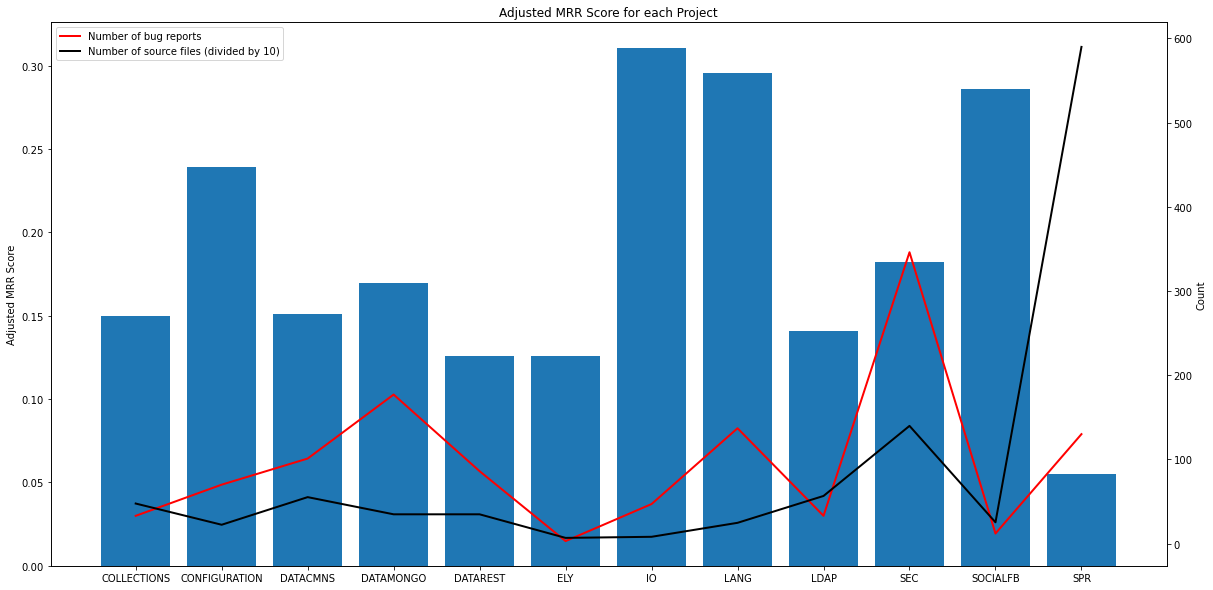

In [83]:
# Get the bug and source file counts
bug_reports.dropna(inplace=True)
bug_report_counts = [(project, len(group)) for project, group in bug_reports.groupby('project')]
source_file_counts = [(project, len(group) / 10) for project, group in source_files.groupby('project')]

# Calculate and plot the MRR
project_scores = calculate_scores(bug_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'd2v_similarities')

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MRR Score')
ax1.bar(range(len(project_scores)), list(project_scores.values()), tick_label=list(project_scores.keys()))

ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in bug_report_counts], [p[1] for p in bug_report_counts], label = "Number of bug reports", color="red", linewidth = 2)
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth = 2)

plt.title('Adjusted MRR Score for each Project')
plt.legend()
plt.show()

# Let's visualize our scores for MAP

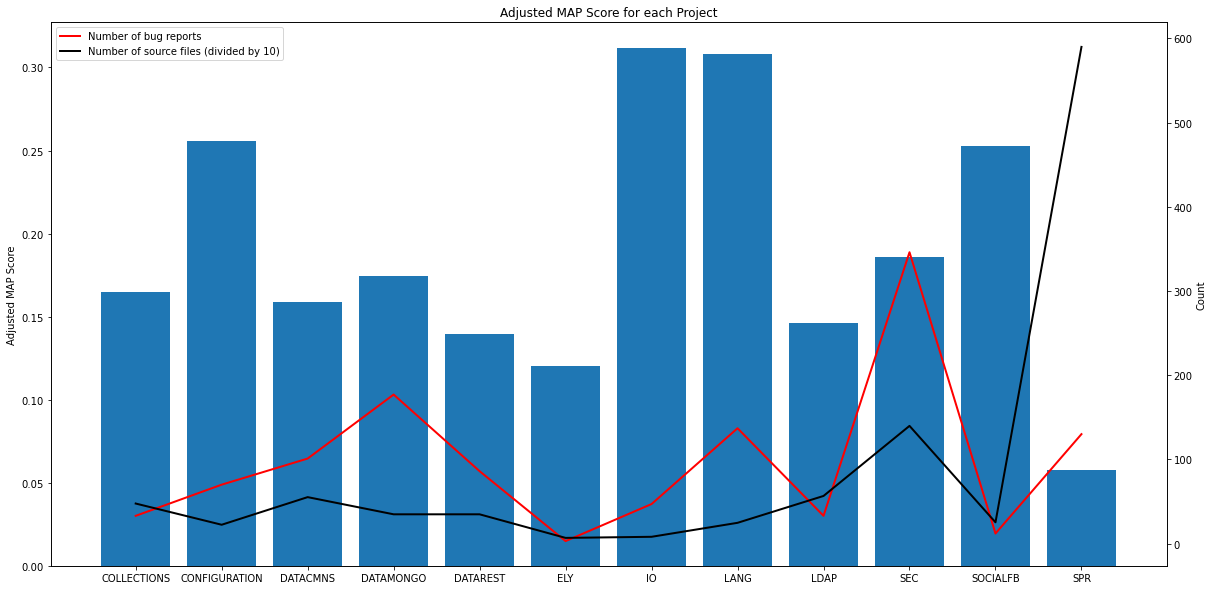

In [84]:
# Get the bug and source file counts
bug_report_counts = [(project, len(group)) for project, group in bug_reports.groupby('project')]
source_file_counts = [(project, len(group) / 10) for project, group in source_files.groupby('project')]

# Calculate and plot the MRR
project_scores = calculate_scores(bug_reports, calculate_average_precision, 'average_precision', 'd2v_similarities')

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MAP Score')
ax1.bar(range(len(project_scores)), list(project_scores.values()), tick_label=list(project_scores.keys()))

ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in bug_report_counts], [p[1] for p in bug_report_counts], label = "Number of bug reports", color="red", linewidth=2)
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth=2)

plt.title('Adjusted MAP Score for each Project')
plt.legend()
plt.show()

# Let's split our bug reports into test and training sets

In [143]:
testing_reports, training_reports = split_testing_training(bug_reports.copy())
testing_reports['d2v_indirect_relevancies'] = np.empty((len(testing_reports), 0)).tolist()
testing_reports['d2v_final_scores'] = np.empty((len(testing_reports), 0)).tolist()

# Let's create a function for creating a bug model

In [99]:
def create_bug_doc2vec(data):
  documents = []
  for row, datum in data.iterrows():
    documents.append((row, datum['text'].split()))
  documents = [TaggedDocument(tup[1], [tup[0]]) for tup in documents]
  return Doc2Vec(documents, vector_size=200, dm=1, window=20, negative=10, workers=5, epochs=40)

# Now let's calculate bug similarities

In [100]:
def compute_doc2vec_bug_similarity(testing_report, training_reports, model):
  # Compute the similarities
  testing_vector = model.infer_vector(testing_report['text'].split())
  scores = model.dv.most_similar(testing_vector, topn=len(model.dv))
  
  # Find all the bug reports linked to F_j
  file_reports = defaultdict()
  for _, training_report in training_reports.iterrows():
    for file in training_report['fix']:
      if file not in file_reports:
        file_reports[file] = []
      file_reports[file].append(training_report)

  # Calculate the SimiScore for each file
  simi_scores = []
  for file in file_reports.keys():
    simi_score_sum = []
    for bug_report in file_reports[file]:
      n_i = len(bug_report['fix'])
      # Find the index of the testing report in the scores
      score_index = 0
      for _, training_report in training_reports.iterrows():
        if training_report.index[0] == bug_report.index[0]:
          break
        score_index += 1
      score = scores[score_index][1]
      simi_score_sum.append(score / n_i)
    simi_scores.append((file, sum(simi_score_sum)))

  # Finally, let's normalize the simi scores
  x_max = max(x[1] for x in simi_scores)
  x_min = min(x[1] for x in simi_scores)
  for i, score in enumerate(simi_scores):
    if x_max - x_min == 0:
      simi_scores[i] = (score[0], 0)
    else:
      normalized = (score[1] - x_min) / (x_max - x_min)
      simi_scores[i] = (score[0], normalized)
  simi_scores = sorted(simi_scores, key = lambda x: x[1], reverse = True)

  return simi_scores

def compute_bug_doc2vec_similarities(testing_reports, training_reports):
  model = create_bug_doc2vec(training_bug_reports)
  for row, testing_report in testing_reports.iterrows():
    scores = compute_doc2vec_bug_similarity(testing_report, training_reports, model)
    testing_reports.at[row, 'd2v_indirect_relevancies'] = scores
  return testing_reports

# Let's compute the doc2vec indirect relevancy

In [144]:
if __name__ == "__main__":
  project_testing_reports = [group for _, group in testing_reports.groupby('project')]
  project_training_reports = [group for _, group in training_reports.groupby('project')]
  if os.name == 'posix':
    with mp.get_context('fork').Pool(processes = len(project_testing_reports)) as p:
      testing_reports = pd.concat(
        p.starmap(
          compute_bug_doc2vec_similarities,
          zip(project_testing_reports, project_training_reports)
        )
      )
  elif os.name == 'nt':
    with mp.Pool(processes = len(project_bug_reports)) as p:
      bug_reports = pd.concat(
        p.starmap(
          compute_similarities,
          zip(project_bug_reports, project_source_files)
        )
      )
  elif os.name == 'java':
    # Sorry
    pass

# Let's calculate the final score

In [89]:
def calculate_d2v_final_scores(testing_reports, α):
  all_final_scores = []
  # Get the final score for each bug report (testing)
  for _, bug_report in testing_reports.iterrows():
    final_scores = []
    indirect_relevancies = bug_report['d2v_indirect_relevancies']
    # Compute the final score
    for similarity in bug_report['d2v_similarities']:
      file = similarity[0]
      score = similarity[1]

      # Find the corresponding indirect relevance score for the similarity to calculate the final score
      corresponding_relevancy = 0
      for ir in indirect_relevancies:
        if ir[0] == file or ir[0] in file or file in ir[0]:
          corresponding_relevancy = ir[1]
          break
      final_score = ((1 - α) * score) + (α * corresponding_relevancy)
      final_scores.append((file, final_score))
    
    # We need to sort to calculate the MRR scores
    final_scores = sorted(final_scores, key = lambda x: x[1], reverse = True)
    all_final_scores.append(final_scores)
  return all_final_scores

In [90]:
α_range = [α / 100 for α in range(0, 105, 5)]

def plot_d2v_scores_vs_α(*args):
  metric_scores = defaultdict()

  for α in α_range:
    all_final_scores = calculate_d2v_final_scores(testing_reports, α)
    testing_reports['d2v_final_scores'] = all_final_scores
    scores = calculate_scores(*args)
    scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse = True))
    for k, v in scores.items():
      if k not in metric_scores:
        metric_scores[k] = []
      metric_scores[k].append(v)
  
  return metric_scores

# Let's plot the MRR scores with different alpha values

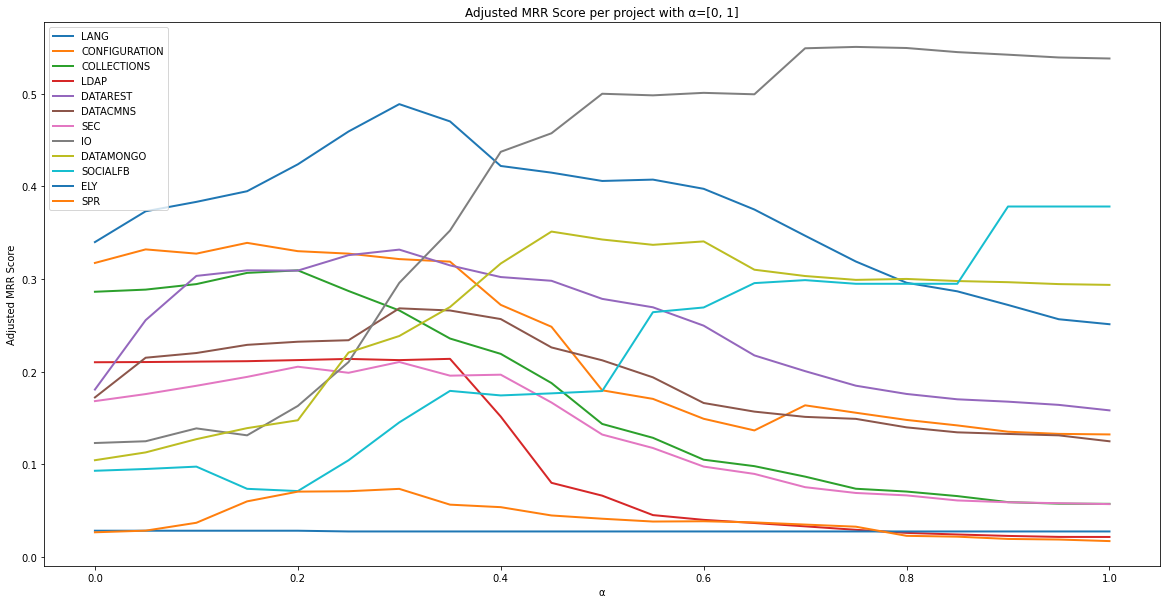

In [91]:
# Plot MRR scores
metric_scores = plot_d2v_scores_vs_α(testing_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'd2v_final_scores')
for k, v in metric_scores.items():
  plt.plot(α_range, v, label = k, linestyle = "-", linewidth=2)
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('Adjusted MRR Score per project with α=[0, 1]')
plt.xlabel('α')
plt.ylabel('Adjusted MRR Score')
plt.legend()
plt.show()

# Let's plot the MAP scores with different alpha values

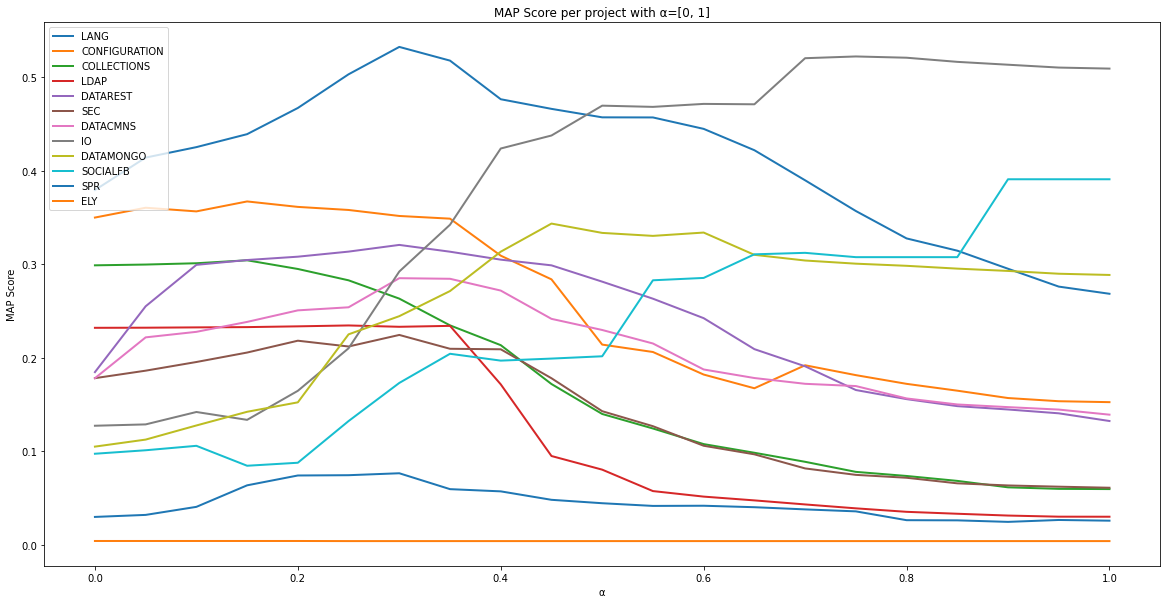

In [92]:
# Plot MAP scores
metric_scores = plot_d2v_scores_vs_α(testing_reports, calculate_average_precision, 'average_precision', 'd2v_final_scores')
for k, v in metric_scores.items():
  plt.plot(α_range, v, label = k, linestyle = "-", linewidth=2)
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('MAP Score per project with α=[0, 1]')
plt.xlabel('α')
plt.ylabel('MAP Score')
plt.legend()
plt.show()

# Let's lock in our favourite alpha value

In [145]:
all_final_scores = calculate_d2v_final_scores(testing_reports, 0.3)
testing_reports['d2v_final_scores'] = all_final_scores

# Let's create an ensemble of TFIDF and Doc2Vec scores

In [153]:
def create_ensemble(bug_reports):
  all_net_scores = []
  for row, bug_report in bug_reports.iterrows():
    # Compute the net score
    tfidf_scores = dict(bug_report['final_scores'])
    d2v_scores = dict(bug_report['d2v_final_scores'])
    net_scores = []
    for key, value in tfidf_scores.items():
      try:
        net_score = (value + d2v_scores[key]) / 2
        net_scores.append((key, net_score))
      except:
        display(bug_report)
    # Normalize and sort the net scores
    x_max = max(x[1] for x in net_scores)
    x_min = min(x[1] for x in net_scores)
    for i, score in enumerate(net_scores):
      if x_max - x_min == 0:
        net_scores[i] = (score[0], 0)
      else:
        normalized = (score[1] - x_min) / (x_max - x_min)
        net_scores[i] = (score[0], normalized)
    net_scores = sorted(net_scores, key=lambda x: x[1], reverse=True)
    all_net_scores.append(net_scores)
  bug_reports['ensemble_scores'] = all_net_scores

# Let's multiprocess to get our ensemble scores

In [154]:
testing_reports['final_scores'] = np.empty((len(testing_reports), 0)).tolist()
testing_reports['final_scores'] = testing_bug_reports['final_scores']
create_ensemble(testing_reports)

# Let's visualize the ensemble scores for MRR

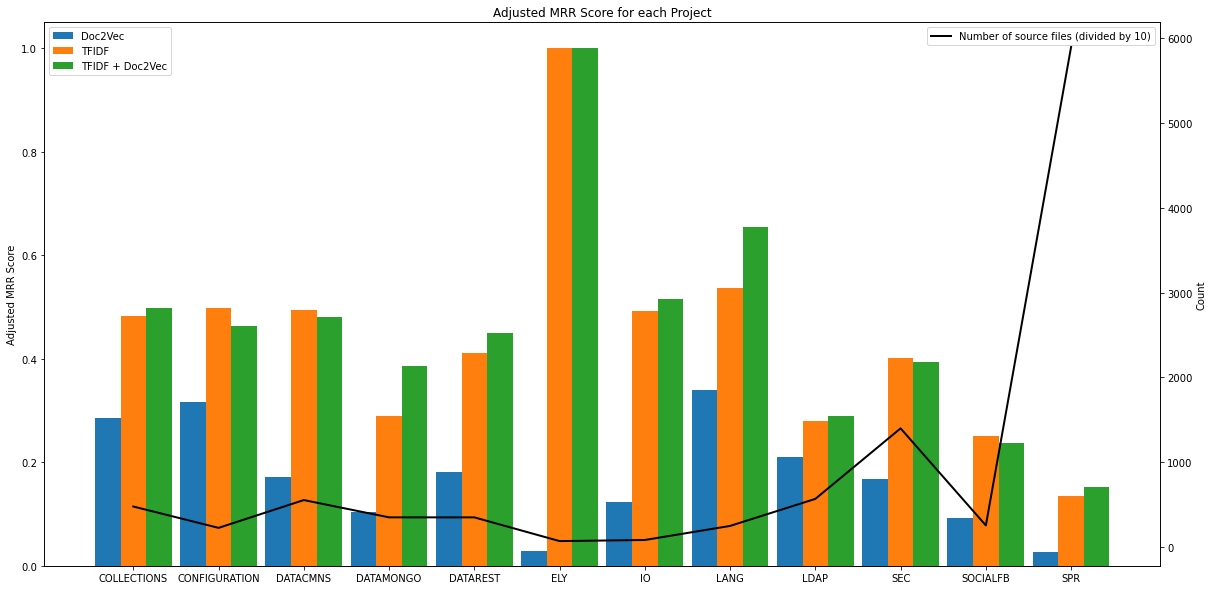

In [341]:
# Get the bug and source file counts
bug_report_counts = [(project, len(group)) for project, group in bug_reports.groupby('project')]
source_file_counts = [(project, len(group)) for project, group in source_files.groupby('project')]

# Calculate and plot the MRR
method2_scores = calculate_scores(testing_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'similarities')
method3_scores = calculate_scores(testing_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'd2v_similarities')
project_scores = calculate_scores(testing_reports, calculate_adjusted_MRR, 'adjusted_MRR', 'ensemble_scores')

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MRR Score')
labels = list(method2_scores.keys())
x = np.arange(len(labels))
width = 0.3
ax1.bar(x - 0.3, list(method3_scores.values()), width, label="Doc2Vec", tick_label=list(method3_scores.keys()))
ax1.bar(x + 0.0, list(method2_scores.values()), width, label="TFIDF")
ax1.bar(x + 0.3, list(project_scores.values()), width, label="TFIDF + Doc2Vec")
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files", color="black", linewidth=2)
ax2.legend(loc="upper right")

plt.title('Adjusted MRR Score for each Project')
plt.legend()
plt.show()

# Let's visualize the ensemble scores for MAP

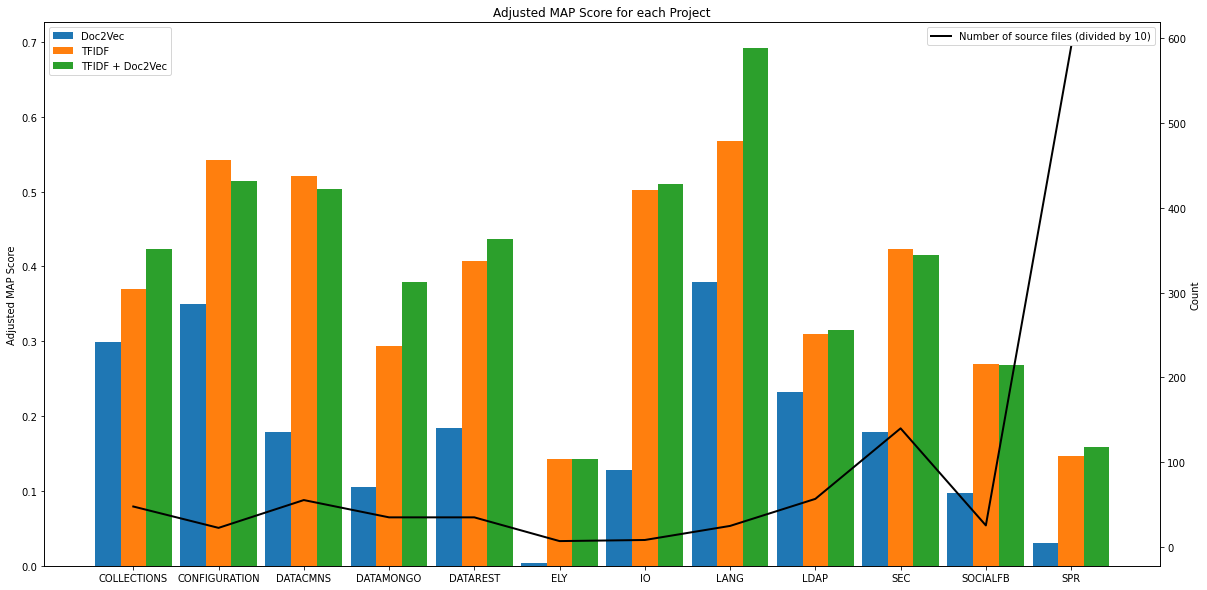

In [339]:
# Get the bug and source file counts
bug_report_counts = [(project, len(group)) for project, group in bug_reports.groupby('project')]
source_file_counts = [(project, len(group)) for project, group in source_files.groupby('project')]

# Calculate and plot the MRR
method2_scores = calculate_scores(testing_reports, calculate_average_precision, 'average_precision', 'similarities')
method3_scores = calculate_scores(testing_reports, calculate_average_precision, 'average_precision', 'd2v_similarities')
project_scores = calculate_scores(testing_reports, calculate_average_precision, 'average_precision', 'ensemble_scores')

# Plot the bars
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
ax1.set_ylabel('Adjusted MAP Score')
labels = list(method2_scores.keys())
x = np.arange(len(labels))
width = 0.3
ax1.bar(x - 0.3, list(method3_scores.values()), width, label="Doc2Vec", tick_label=list(method3_scores.keys()))
ax1.bar(x + 0.0, list(method2_scores.values()), width, label="TFIDF")
ax1.bar(x + 0.3, list(project_scores.values()), width, label="TFIDF + Doc2Vec")
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.set_ylabel('Count')
ax2.plot([p[0] for p in source_file_counts], [p[1] for p in source_file_counts], label = "Number of source files (divided by 10)", color="black", linewidth=2)
ax2.legend(loc="upper right")

plt.title('Adjusted MAP Score for each Project')
plt.legend()
plt.show()

# Please ignore the remaining code. I tried to apply some sort of gravity algorithm to promote similar files, but didn't find anything worth writing about.

# Let's calculate source code similarity

In [300]:
# def calculate_source_similarities(source_files):
#   model = create_source_doc2vec(source_files)
#   for row, source_file in source_files.iterrows():
#     # Get the similarities
#     similarities = model.dv.most_similar(source_file['filename'], topn=40)
#     similarities = sorted(similarities, key = lambda x: x[1], reverse = True)
#     source_files.at[row, 'file_similarities'] = similarities
#   return source_files

# Let's use multiprocessing to find all source file similarities

In [301]:
# if __name__ == "__main__":
#   source_files['file_similarities'] = np.empty((len(source_files), 0)).tolist()
#   project_source_files = [group for _, group in source_files.groupby('project')]
#   if os.name == 'posix':
#     with mp.get_context('fork').Pool(processes = len(project_source_files)) as p:
#       source_files = pd.concat(
#         p.starmap(
#           calculate_source_similarities,
#           zip(project_source_files)
#         )
#       )
#   elif os.name == 'nt':
#     with mp.Pool(processes = len(project_bug_reports)) as p:
#       bug_reports = pd.concat(
#         p.starmap(
#           compute_similarities,
#           zip(project_bug_reports, project_source_files)
#         )
#       )
#   elif os.name == 'java':
#     # Sorry
#     pass

# Calculating Rank Force

In [305]:
# def re_rank(bug_reports, source_files):
#   updated = []
#   for row, bug_report in bug_reports.iterrows():
#     final_scores = bug_report['ensemble_scores']
#     forces = []
#     # Calculate the force for each file
#     for i, final in enumerate(final_scores):
#       file = final[0]
#       score = final[1]
#       similarities = dict(list(dict(source_files[source_files['filename'] == file]['file_similarities']).values())[0])
#       force = 1
#       λ = 3
#       # Calculate positive force
#       for j in range(0, i):
#         denom = pow((j + 1), λ)
#         other_file = final_scores[j][0]
#         similarity = [value for key, value in similarities.items() if other_file in key]
#         if len(similarity) != 0:
#           force += similarity[0] / denom
#       # Calculate negative force
#       for j in range(i + 1, len(final_scores)):
#         denom = pow(j, λ)
#         other_file = final_scores[j][0]
#         similarity = [value for key, value in similarities.items() if other_file in key]
#         if len(similarity) != 0:
#           force -= (similarity[0] / denom) / λ
#       forces.append(force)
    
#     # Consolidate force and ranks
#     updated_ranks = []
#     for force, final in zip(forces, final_scores):
#       score = final[1] + final[1] * force
#       updated_ranks.append((final[0], score))
#     updated_ranks = sorted(updated_ranks, key = lambda x: x[1], reverse = True)
#     updated.append(updated_ranks)
  
#   bug_reports['ensemble_scores'] = updated
#   return bug_reports

# Let's multiprocess, this will take a while...

In [308]:
# if __name__ == "__main__":
#   # Create project groups for testing and training bugs and process them separately
#   testing = [group for _, group in testing_reports.copy().groupby('project')]
#   files = [group for _, group in source_files.groupby('project')]
#   if os.name == 'posix':
#     with mp.get_context('fork').Pool(processes = len(project_bug_reports)) as p:
#       final_bug_reports = pd.concat(
#         p.starmap(
#           re_rank,
#           zip(testing, files)
#         )
#       )
#       display(final_bug_reports)
#   elif os.name == 'nt':
#     with mp.Pool(processes = len(project_bug_reports)) as p:
#       final_bug_reports = pd.concat(
#         p.starmap(
#           re_rank,
#           zip(testing, files)
#         )
#       )
#   elif os.name == 'java':
#     # Sorry
#     pass